[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/peteyeh/celltrack/HEAD)

In [1]:
%matplotlib inline

import cv2
import matplotlib.colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import six

from collections import Counter, OrderedDict
from radiomics import featureextractor
from SimpleITK import GetImageFromArray
from skimage.filters import threshold_multiotsu
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

from displaytools import *
from improcessing import *

extractor = featureextractor.RadiomicsFeatureExtractor()
# Enable everything but shape (3D) and glcm.SumAverage
extractor.disableAllFeatures()
extractor.enableFeaturesByName(firstorder=[],
                               shape2D=[],
                               glcm=['Autocorrelation', 'JointAverage', 'ClusterProminence',
                                     'ClusterShade', 'ClusterTendency', 'Contrast',
                                     'Correlation', 'DifferenceAverage', 'DifferenceEntropy',
                                     'DifferenceVariance', 'JointEnergy', 'JointEntropy',
                                     'Imc1', 'Imc2', 'Idm', 'Idmn', 'Id', 'Idn',
                                     'InverseVariance', 'MaximumProbability', 'SumEntropy',
                                     'SumSquares'],
                               glszm=[],
                               glrlm=[],
                               ngtdm=[],
                               gldm=[])

scaler = StandardScaler()
pca = PCA(n_components='mle')
tsne = TSNE(learning_rate='auto', init='pca', random_state=0)

In [2]:
# Crops image to a region of interest
def crop_image(image):
    x, y, w, h = cv2.boundingRect(image)
    return image[y:y+h, x:x+w]

def display_classifications(image, centroids, labels):
    c = Counter(labels)
    for k in sorted(c):
        print("Class %s: %i (%.2f%%)" % (k, c[k], c[k]*100/sum(c.values())))
    plt.figure(dpi=240)
    plt.axis('off')
    plt.imshow(image, interpolation='nearest', cmap='gray')
    plt.scatter(*zip(*centroids), s=20, c=labels, marker='+', cmap=colormap, linewidths=1)
    plt.show()
    
def display_rois(image, masks, labels):
    for c in range(labels.min(), labels.max()+1):
        indices = np.where(labels==c)[0]
        print("Class %i, with %i ROIs:" % (c, len(indices)))
        masked = image*masks[indices]
        cropped = list(map(crop_image, masked))
        display_image_array(cropped, columns=10, dpi=300)

def display_tsne(df):
    transformed = tsne.fit_transform(df)
    plt.scatter(transformed[:,0], transformed[:,1], s=5, c=labels)
    plt.show()

def extract_features(image, mask_image, size_thresh=75):
    num_components, labelled, stats, centroids = \
            cv2.connectedComponentsWithStats(mask_image, connectivity=8)

    features = OrderedDict()
    masks = []

    for i in range(1, len(stats)):  # index 0 is the background component
        size = stats[i, -1]
        if size < size_thresh:
            continue
        mask = np.uint8(labelled == i)
        masks += [mask,]
        result = extractor.execute(GetImageFromArray(image),
                                   GetImageFromArray(mask))
        if len(features) == 0:
            features['x'] = [int(centroids[i][0])]
            features['y'] = [int(centroids[i][1])]
            for key, val in six.iteritems(result):
                if key.startswith("original_"):
                    features[key] = [val]
        else:
            features['x'] += [int(centroids[i][0])]
            features['y'] += [int(centroids[i][1])]
            for key, val in six.iteritems(result):
                if key.startswith("original_"):
                    features[key] += [val]

    return pd.DataFrame.from_dict(features).set_index(['x', 'y']), np.array(masks)

def get_mask_image(image, params, adaptive=False, display_images=False):
    if adaptive:
        binarized = cv2.adaptiveThreshold(image, 255,
                                          cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                          cv2.THRESH_BINARY_INV,
                                          params['thresh_ks'], params['C'])
    else:
        image = cv2.createCLAHE(clipLimit=params['clipLimit'], tileGridSize=(8,8)) \
                   .apply(image)
        image = cv2.fastNlMeansDenoising(image, h=params['denoising'])
        threshold, binarized = \
            cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    
    filled = apply_imfill(apply_closure(binarized, kernel_size=params['closure_ks']))

    if display_images:
        display_image_array([image, binarized, filled], columns=3, dpi=450)

    return filled

def process_features(df):
    return pd.DataFrame(pca.transform(scaler.transform(df.values)),
                        index=df.index)

# User-defined parameters

In [3]:
params = {
    # image closure kernel size
    'closure_ks': 3,

    # adaptive thresholding
    'thresh_ks': 151,
    'C': 8,

    # histogram equalization
    'clipLimit': 4,
    'denoising': 5,
}

# Fit and classify on control image

## Create mask image and extract raw features

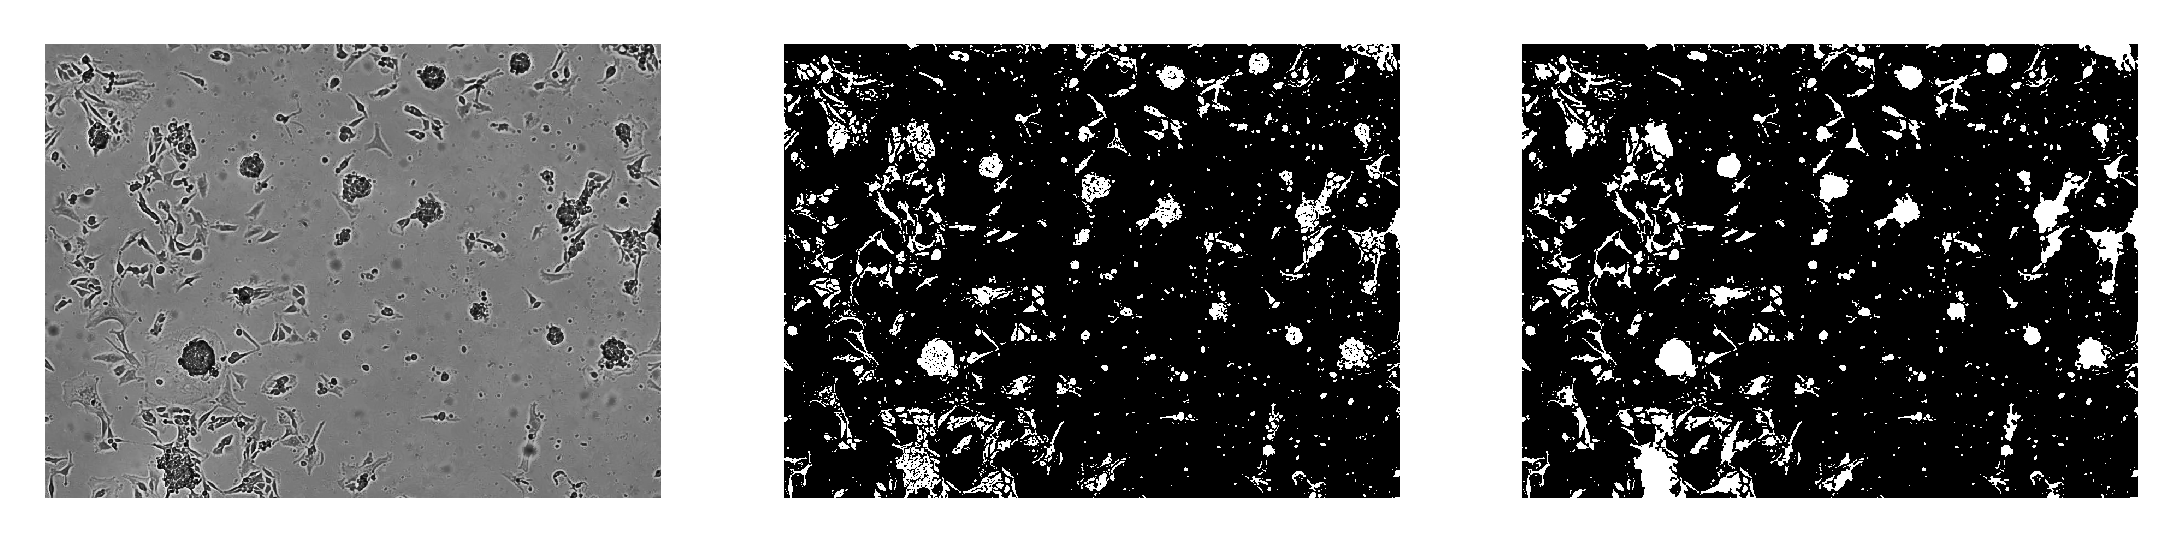

original_shape2D_Elongation  original_shape2D_MajorAxisLength  \
x   y                                                                    
235 3                       0.467039                         20.604980   
475 3                       0.619026                         15.896861   
541 14                      0.517569                         31.669981   
575 3                       0.397389                         25.371088   
621 7                       0.811047                         15.978203   
...                              ...                               ...   
419 818                     0.378814                         39.873253   
177 810                     0.484699                         21.177954   
407 815                     0.567217                         15.808865   
101 823                     0.388184                         27.501762   
169 825                     0.665485                         16.851633   

        original_shape2D_MaximumDiameter original_shape2D_MeshSurface  \
x   y                                                                   
235 3                 21.213203435596427                        123.5   
475 3                  17.08800749063506                        109.5   
541 14                30.528675044947494                        336.5   
575 3                 25.495097567963924                        185.5   
621 7                  17.08800749063506                        154.5   
...                                  ...                          ...   
419 818                 35.4400902933387                        220.5   
177 810                22.20360331117452                        166.5   
407 815               18.027756377319946                        105.5   
101 823                33.54101966249684                        214.5   
169 825               18.867962264113206                        133.5   

         original_shape2D_MinorAxisLength original_shape2D_Perimeter  \
x   y                                                                  
235 3                            9.623334          59.79898987322329   
475 3                            9.840574          45.79898987322329   
541 14                          16.391415          90.18376618407363   
575 3                           10.082187           67.7989898732233   
621 7                           12.959069          52.62741699796948   
...                                   ...                        ...   
419 818                         15.104537         123.59797974644675   
177 810                         10.264931          57.11269837220805   
407 815                          8.967052          46.62741699796949   
101 823                         10.675740          82.52691193458116   
169 825                         11.214516         50.727922061357845   

        original_shape2D_PerimeterSurfaceRatio  original_shape2D_PixelSurface  \
x   y                                                                           
235 3                       0.4842023471516056                          124.0   
475 3                      0.41825561528057803                          110.0   
541 14                       0.268005248689669                          337.0   
575 3                       0.3654932068637375                          186.0   
621 7                       0.3406305307311941                          155.0   
...                                        ...                            ...   
419 818                      0.560535055539441                          221.0   
177 810                      0.343019209442691                          167.0   
407 815                     0.4419660378954454                          106.0   
101 823                     0.3847408481798656                          215.0   
169 825                    0.37998443491653816                          134.0   

         original_shape2D_Sphericity original_firstorder_10Percentile  ...  \
x   y                      

In [4]:
raw_image = cv2.imreadmulti('source_images/Control.tif')[1][0]
mask_image = get_mask_image(raw_image, params, display_images=True)
df, masks = extract_features(raw_image, mask_image)
display(df)

## Scale features and reduce dimensions

In [5]:
scaler.fit(df.values)
pca.fit(df.values)

df = process_features(df)
display(df)

0             1             2           3           4   \
x   y                                                                       
235 3   -5.516901e+06 -49067.250369 -11291.359716 -551.066914  118.789651   
475 3   -5.516901e+06 -49072.480848 -11292.274674 -548.533527  116.630785   
541 14  -5.516901e+06 -49072.481324 -11292.249165 -548.482026  116.650111   
575 3   -5.516901e+06 -49072.480651 -11292.279856 -548.529105  116.591492   
621 7   -5.516901e+06 -49072.481627 -11292.313594 -548.500408  116.678145   
...               ...           ...           ...         ...         ...   
419 818 -5.516901e+06 -49072.480798 -11292.305273 -548.490122  116.611056   
177 810 -5.516901e+06 -49072.480827 -11292.283393 -548.516005  116.601296   
407 815 -5.516901e+06 -49072.480026 -11292.270315 -548.551928  116.532475   
101 823 -5.516901e+06 -49072.481030 -11292.226888 -548.499444  116.613890   
169 825 -5.516901e+06 -49072.479325 -11292.196034 -548.649508  116.495983   

                 5           6          7           8         9   ...  \
x   y                                                             ...   
235 3    111.166773  430.239566  98.303777  206.177719  0.852825  ...   
475 3    106.882471  429.987068  97.726765  206.037573  1.305367  ...   
541 14   106.522583  429.101598  97.816315  204.693797  1.450297  ...   
575 3    107.014295  430.224080  97.904539  205.577286  1.415707  ...   
621 7    106.507311  429.279454  97.704733  206.075695  1.535905  ...   
...             ...         ...        ...         ...       ...  ...   
419 818  106.936658  430.049293  97.866360  205.121046  1.858849  ...   
177 810  107.012756  430.270933  97.908933  205.699286  1.363731  ...   
407 815  107.422709  431.018777  97.835826  205.610595  0.872684  ...   
101 823  106.753232  429.572494  97.640226  204.890110  1.355644  ...   
169 825  107.417491  430.980611  98.037979  205.989401  1.210783  ...   

               87        88        89        90        91        92        93  \
x   y                                                                           
235 3    0.900082 -0.408937 -0.559517  0.715848  0.267777  1.962545 -1.483269   
475 3    0.562990  0.596328  0.822430 -0.305321 -1.117932  0.626127 -0.146296   
541 14  -0.018231 -0.359723  0.820439 -0.855690 -0.976843 -0.562985 -0.577098   
575 3    0.478175  0.155261  0.637544 -0.482807 -1.386929  0.241029 -0.560289   
621 7    0.550028  0.163216  0.528488 -1.066790 -1.558297  0.078227  0.155089   
...           ...       ...       ...       ...       ...       ...       ...   
419 818  0.077739  0.198321  0.369836 -0.725094 -1.322227  0.253780 -0.051877   
177 810  0.609838  0.826720  0.330779 -0.644379 -1.814058  0.893314  0.131597   
407 815  0.774597  0.669027  0.618656 -0.083940 -1.479095  1.098367 -0.702395   
101 823 -0.014668  0.047348  0.909137 -0.729478 -0.974713  0.030896 -0.296401   
169 825  0.924147  1.551753  0.456653 -0.054775 -2.009517  2.099012  0.181153   

               94        95        96  
x   y                                  
235 3   -0.482573  0.265380 -0.057280  
475 3   -0.321340 -1.141325  0.225772  
541 14   0.048493 -1.442915  0.272842  
575 3   -0.340499 -1.085408  0.214390  
621 7   -0.133461 -1.675766  0.316682  
...           ...       ...       ...  
419 818  0.003152 -1.307864  0.258501  
177 810 -0.275319 -1.308601  0.262614  
407 815 -0.739027 -0.648458  0.133615  
101 823  0.014136 -1.318885  0.250508  
169 825 -0.643432 -0.822560  0.176943  

[206 rows x 97 columns]

## Determine number of clusters

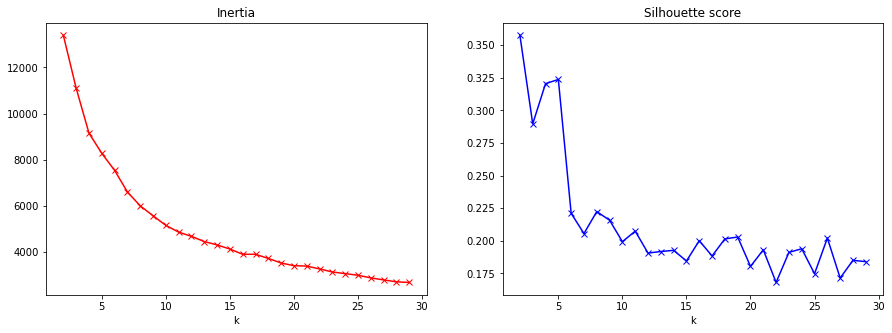

In [6]:
inertias = []
silhouette_scores = []
K = range(2, 30)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0)
    labels = kmeans.fit_predict(df)
    inertias += [kmeans.inertia_,]
    silhouette_scores += [silhouette_score(df, labels),]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.plot(K, inertias, 'rx-')
ax1.set(xlabel='k', title='Inertia')
ax2.plot(K, silhouette_scores,'bx-')
ax2.set(xlabel='k', title='Silhouette score')
plt.show()

## Fit and classify using silhouette score

Class 0: 123 (59.71%)
Class 1: 9 (4.37%)
Class 2: 55 (26.70%)
Class 3: 19 (9.22%)


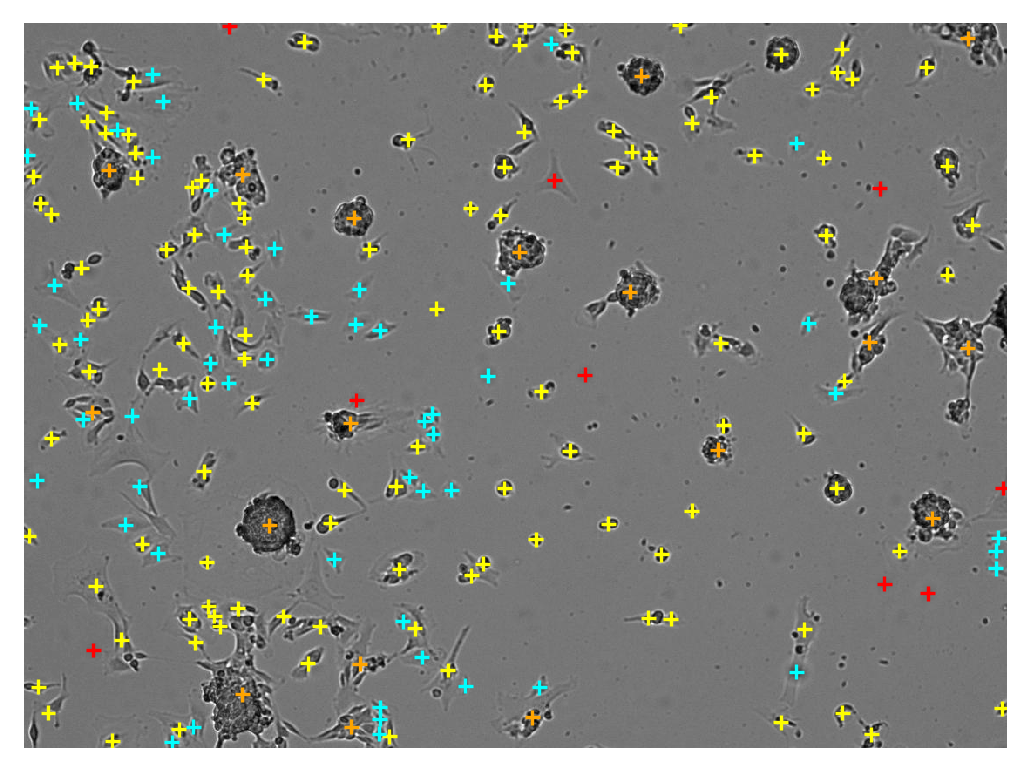

In [7]:
# Manually select k based on visual inspection above
k = 4

# Classification colors (include k colors, or use colormap string)
colormap = matplotlib.colors.ListedColormap(['yellow', 'red', 'cyan', 'orange'])

kmeans = KMeans(n_clusters=k, random_state=0)
kmeans.fit(df)
labels = kmeans.predict(df)
display_classifications(raw_image, df.index, labels)

Class 0, with 123 ROIs:


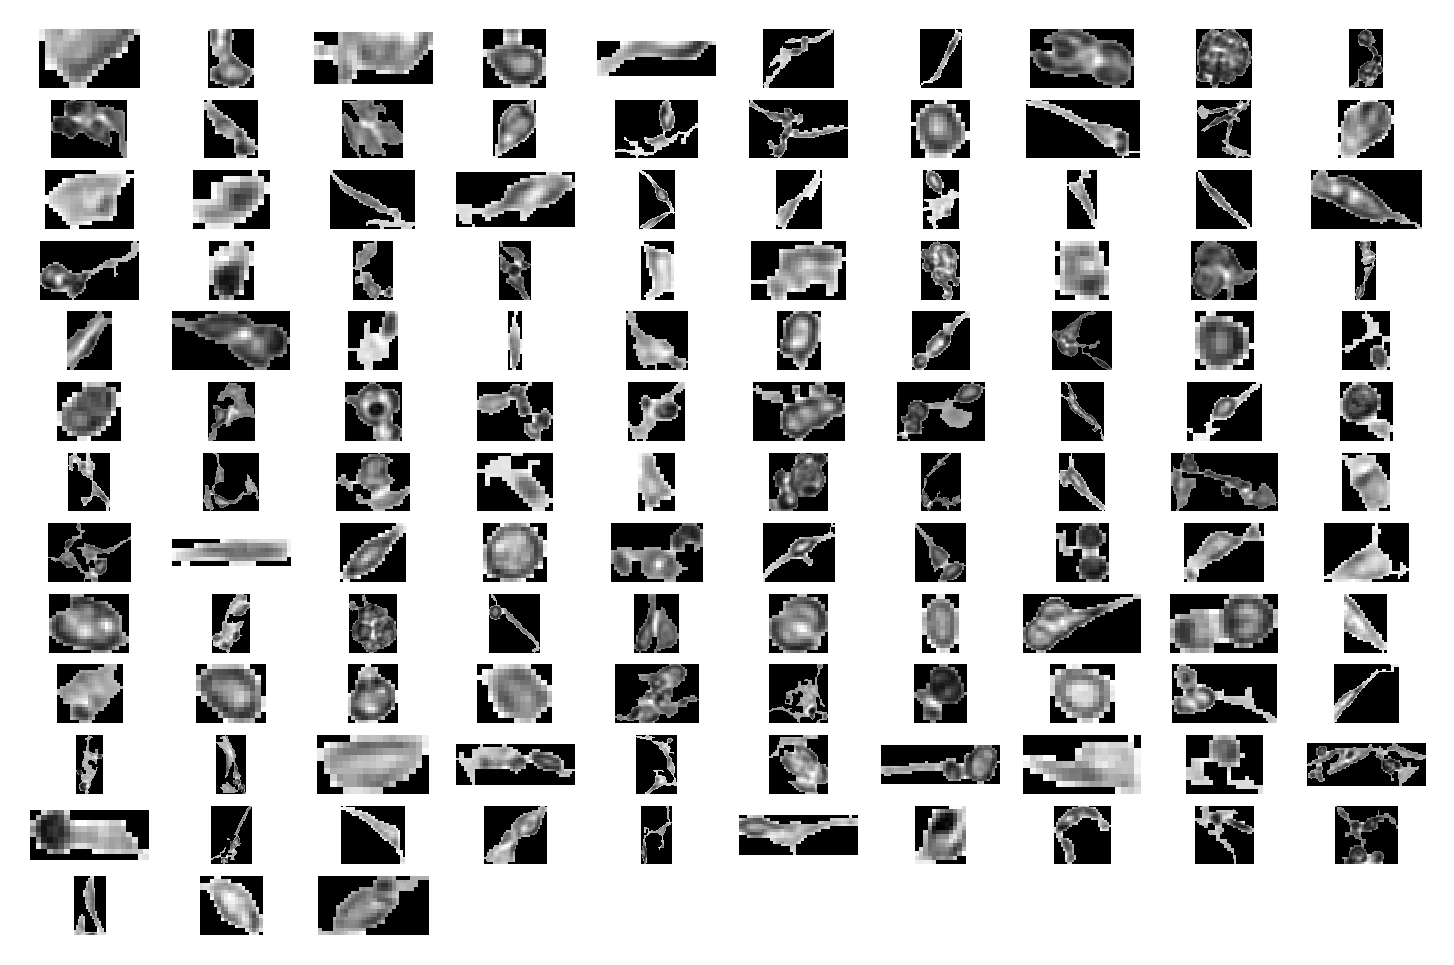

Class 1, with 9 ROIs:


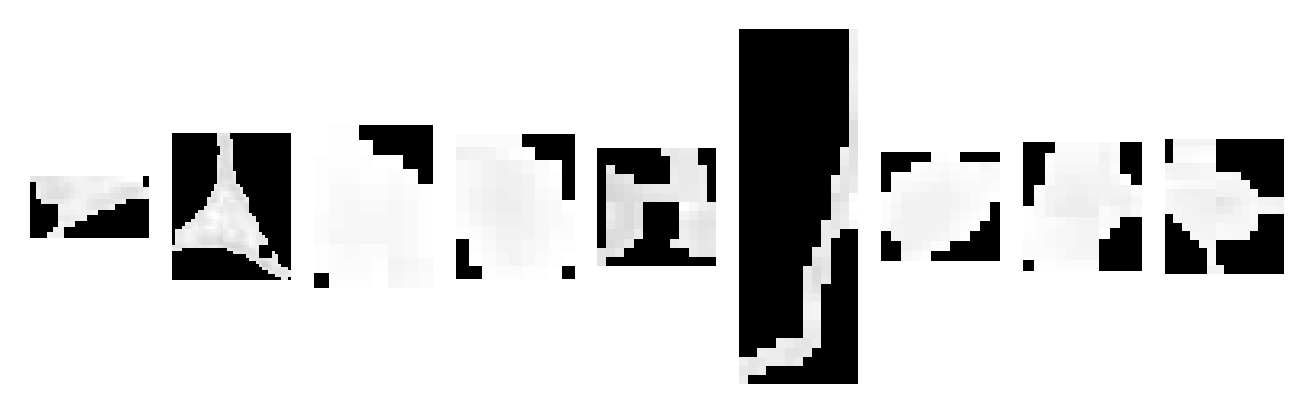

Class 2, with 55 ROIs:


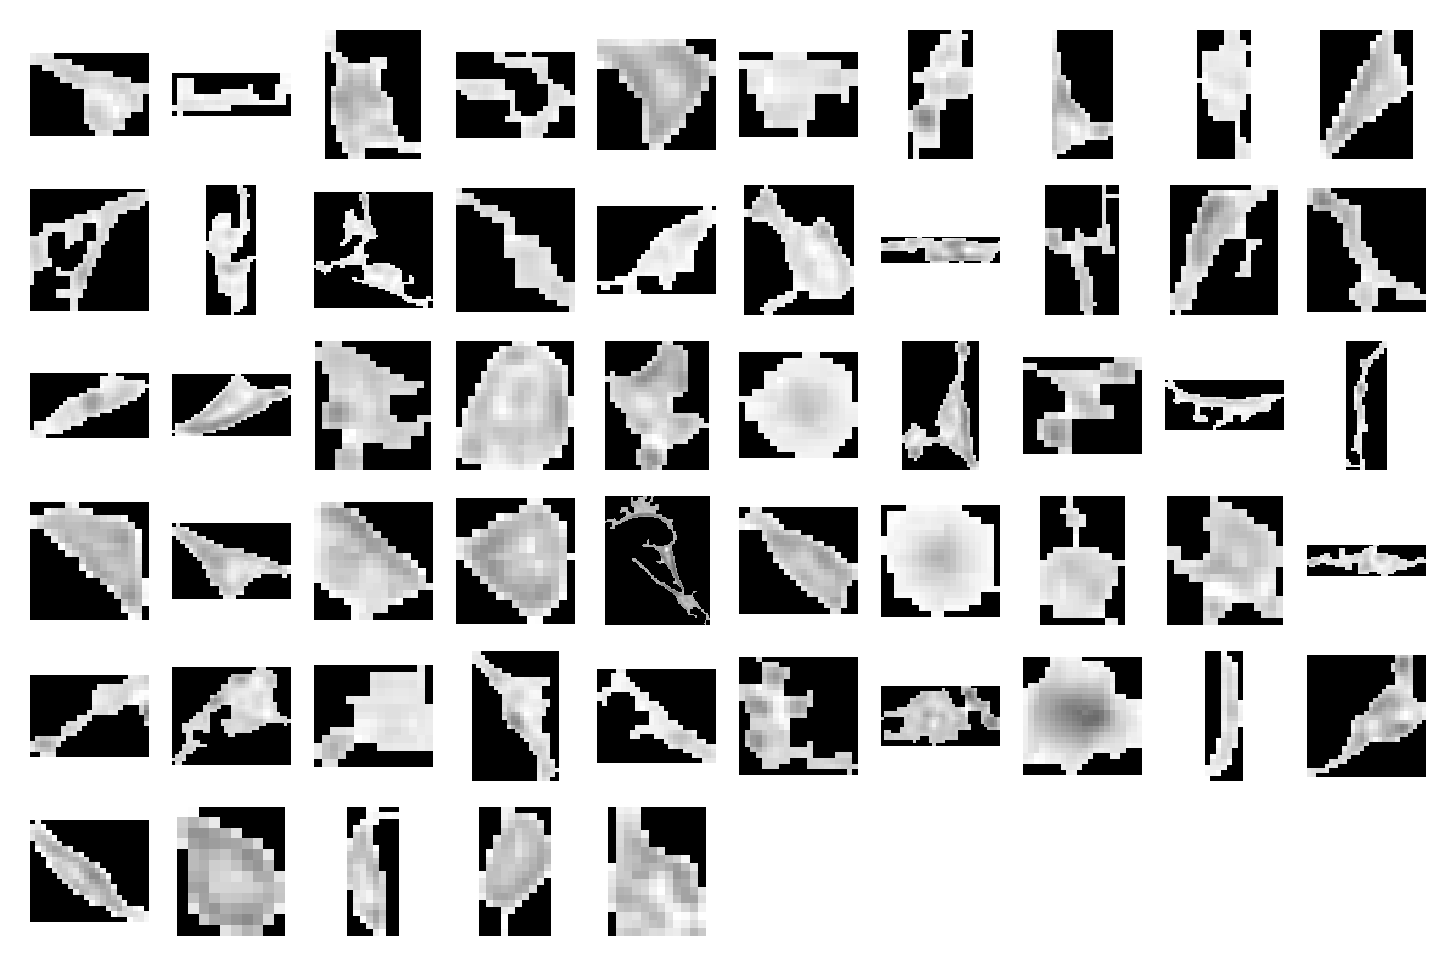

Class 3, with 19 ROIs:


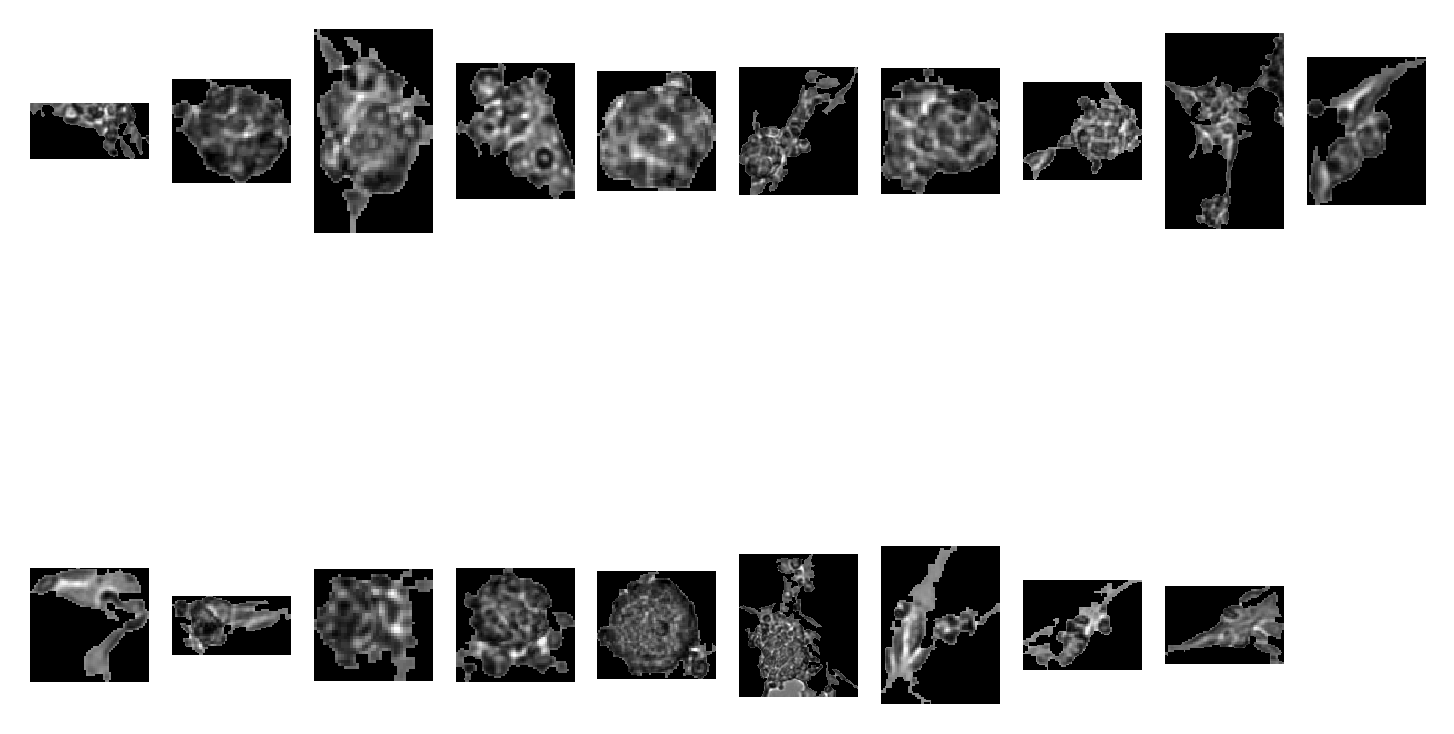

In [8]:
display_rois(raw_image, masks, labels)

## Cluster visualization

/Users/peteyeh/miniconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


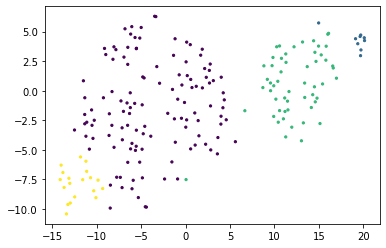

In [9]:
display_tsne(df)

# Experiment w/ multi-Otsu

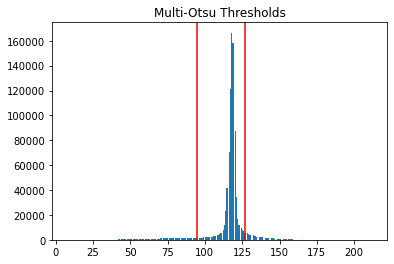

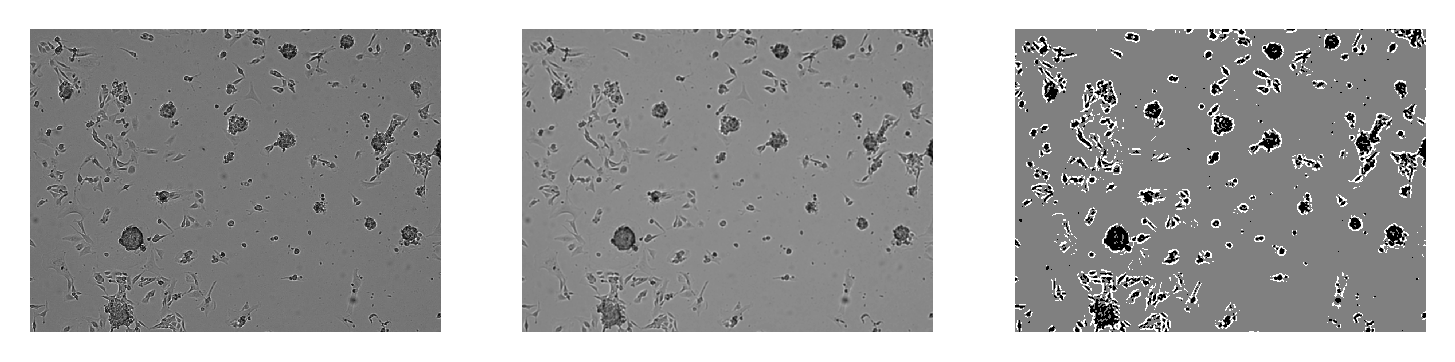

In [10]:
blurred = apply_blur(raw_image, 5)
thresholds = threshold_multiotsu(blurred)
multi_otsu_regions = np.digitize(blurred, bins=thresholds)

plt.hist(blurred.ravel(), bins=255)
plt.title('Multi-Otsu Thresholds')
for thresh in thresholds:
    plt.axvline(thresh, color='r')

display_image_array([raw_image, blurred, multi_otsu_regions],
                    columns=3, dpi=300)

# Classify cells on adherent image

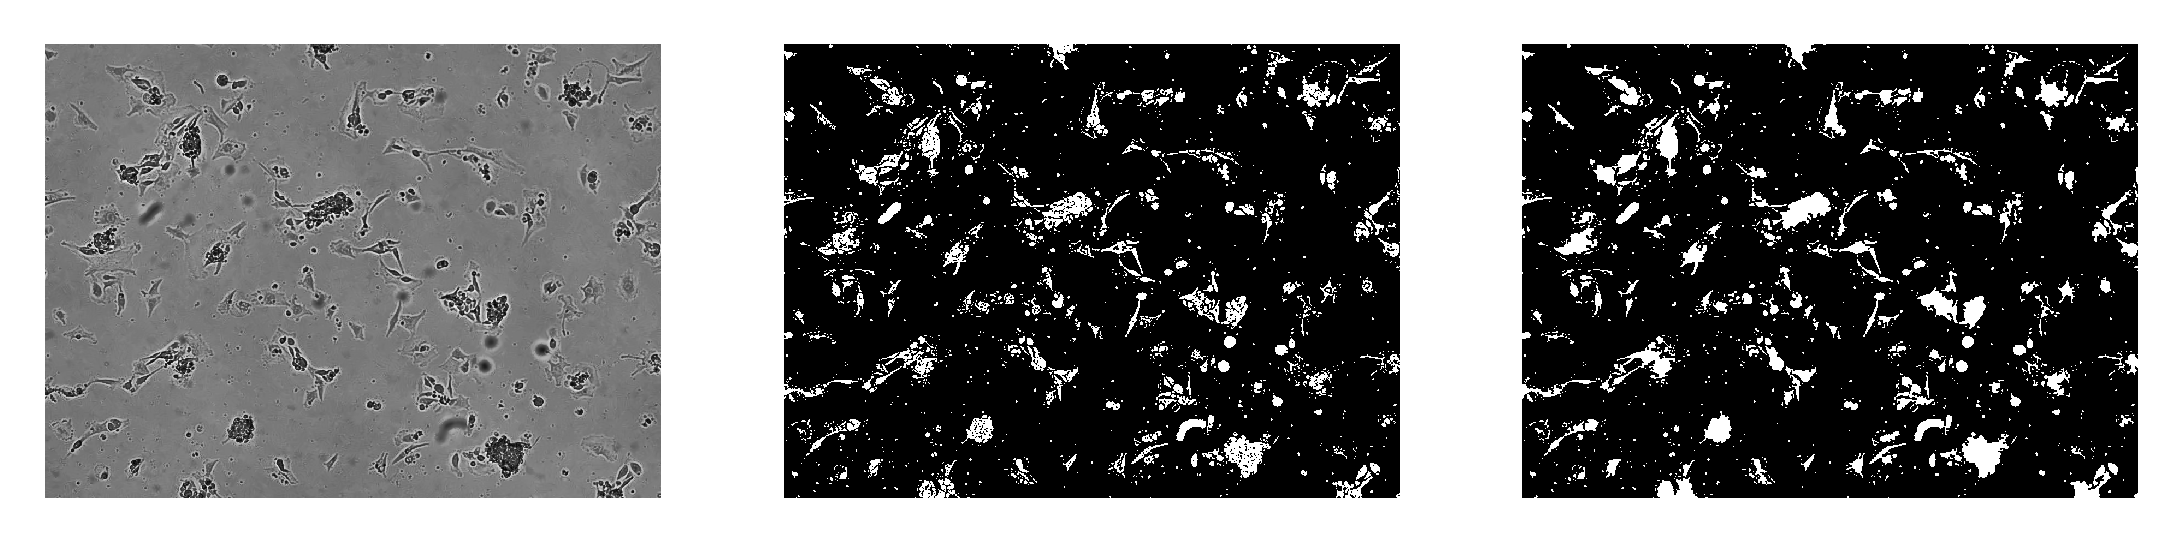

Class 0: 68 (41.98%)
Class 1: 6 (3.70%)
Class 2: 65 (40.12%)
Class 3: 23 (14.20%)


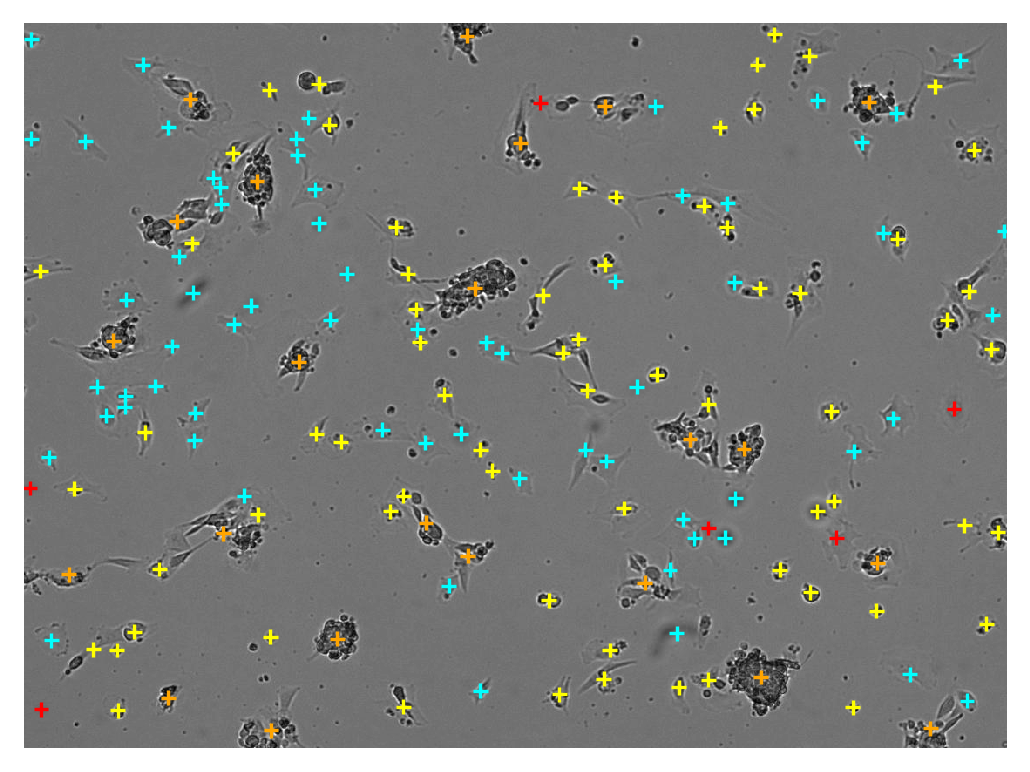

In [11]:
raw_image = cv2.imreadmulti('source_images/Adherent.tif')[1][0]
mask_image = get_mask_image(raw_image, params, display_images=True)
df, masks = extract_features(raw_image, mask_image)
df = process_features(df)
labels = kmeans.predict(df)
display_classifications(raw_image, df.index, labels)

Class 0, with 68 ROIs:


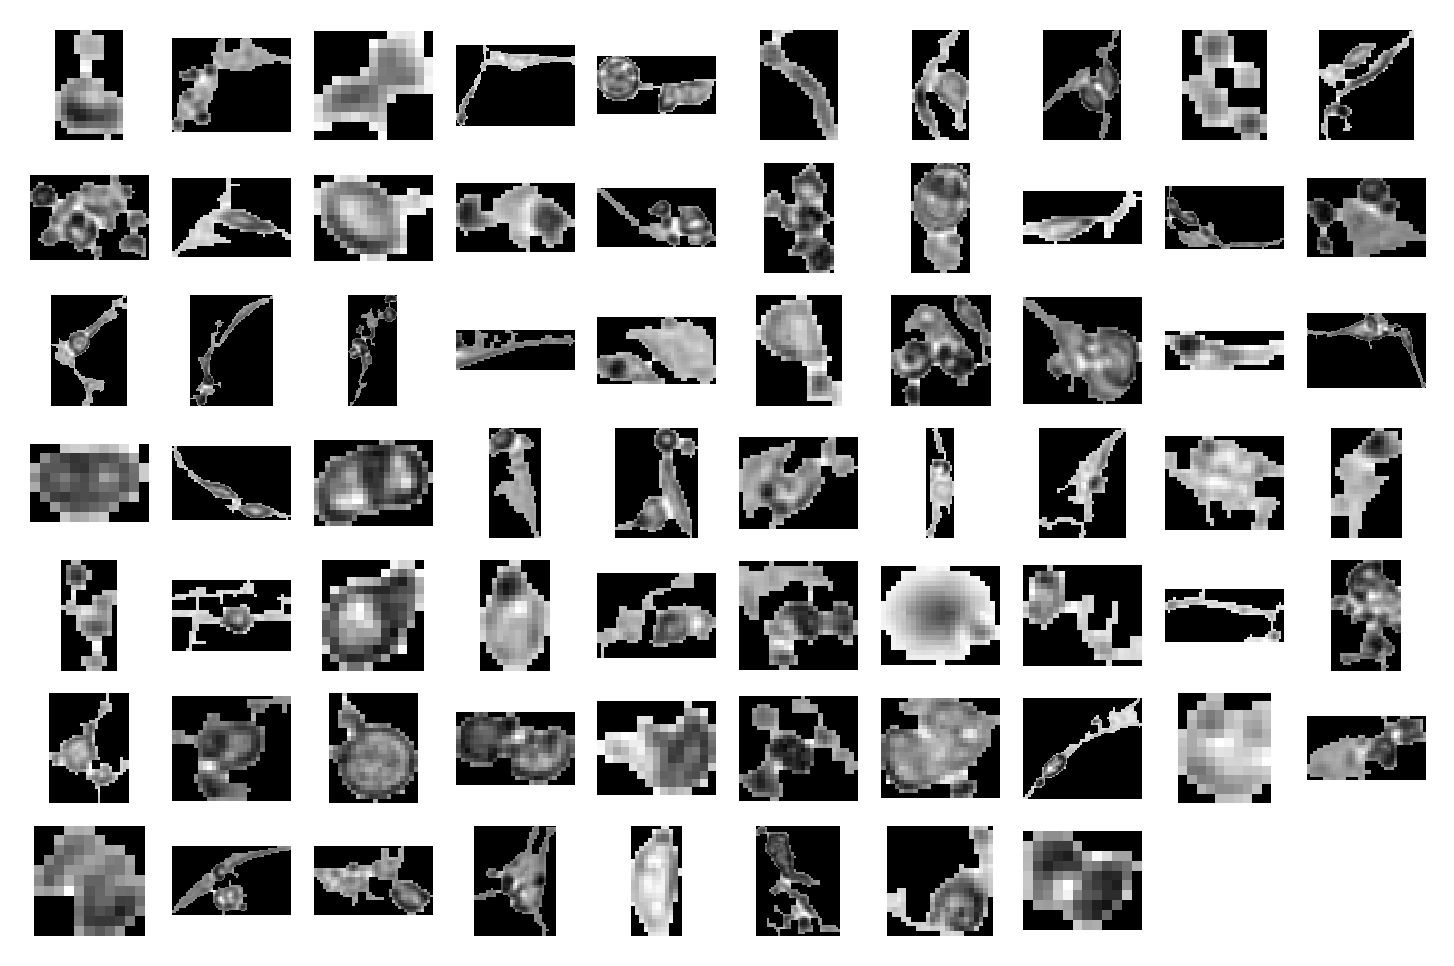

Class 1, with 6 ROIs:


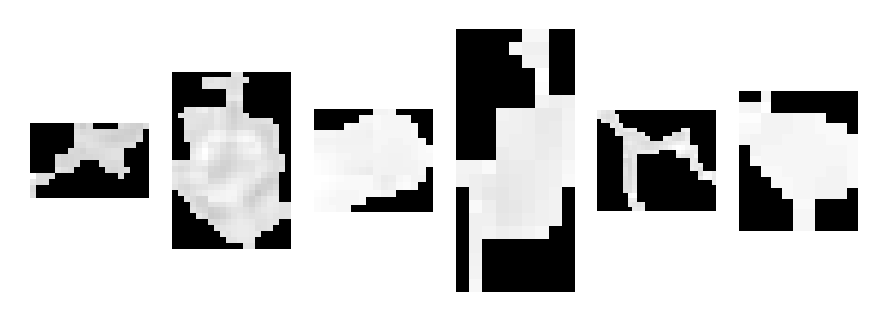

Class 2, with 65 ROIs:


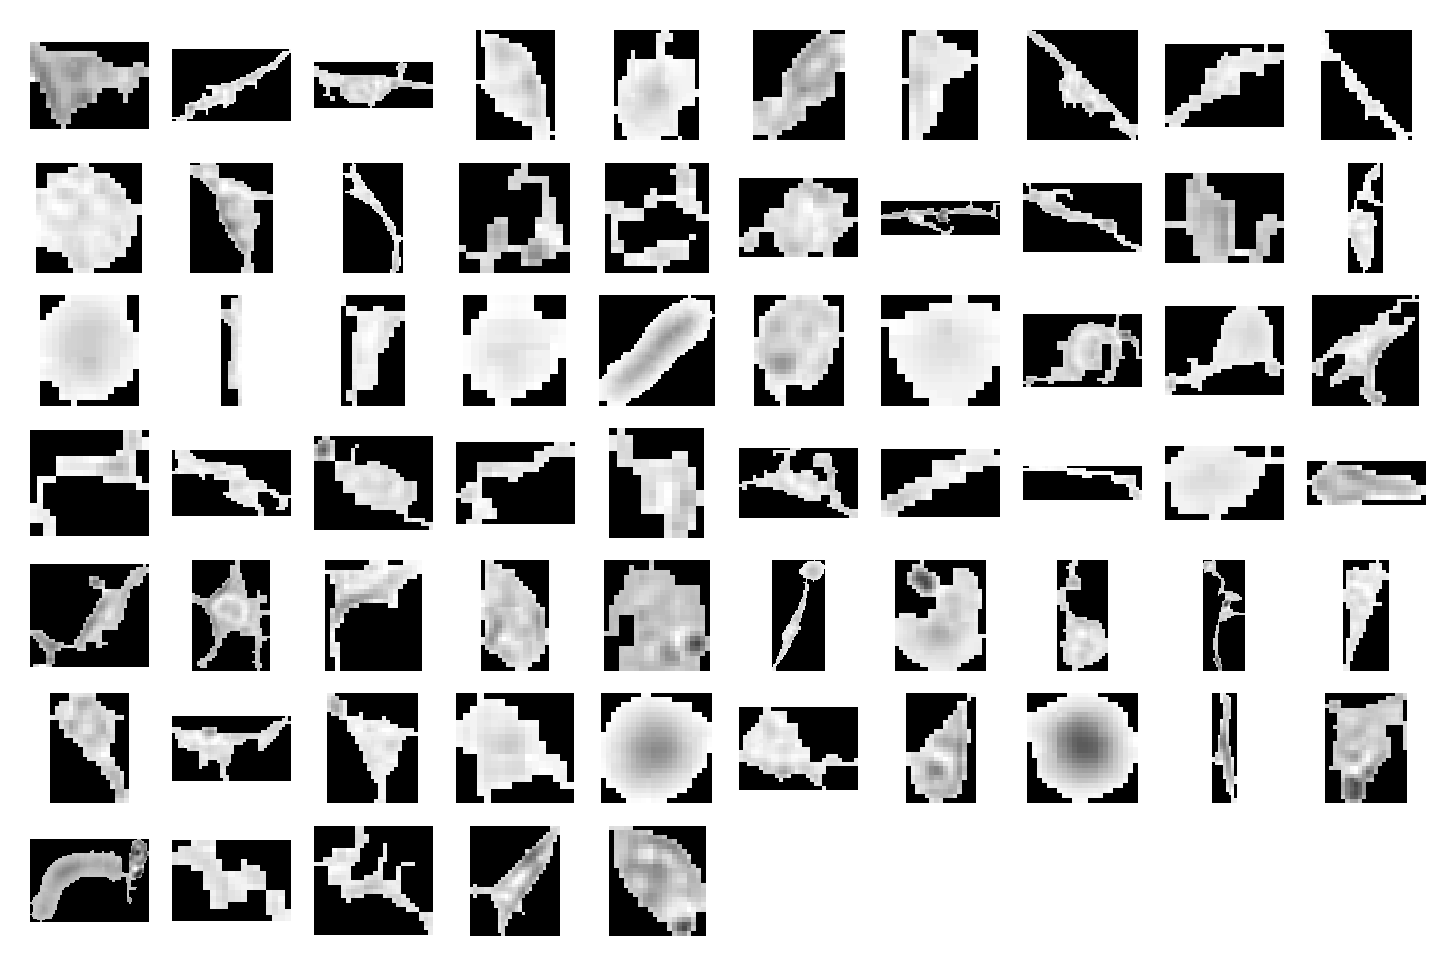

Class 3, with 23 ROIs:


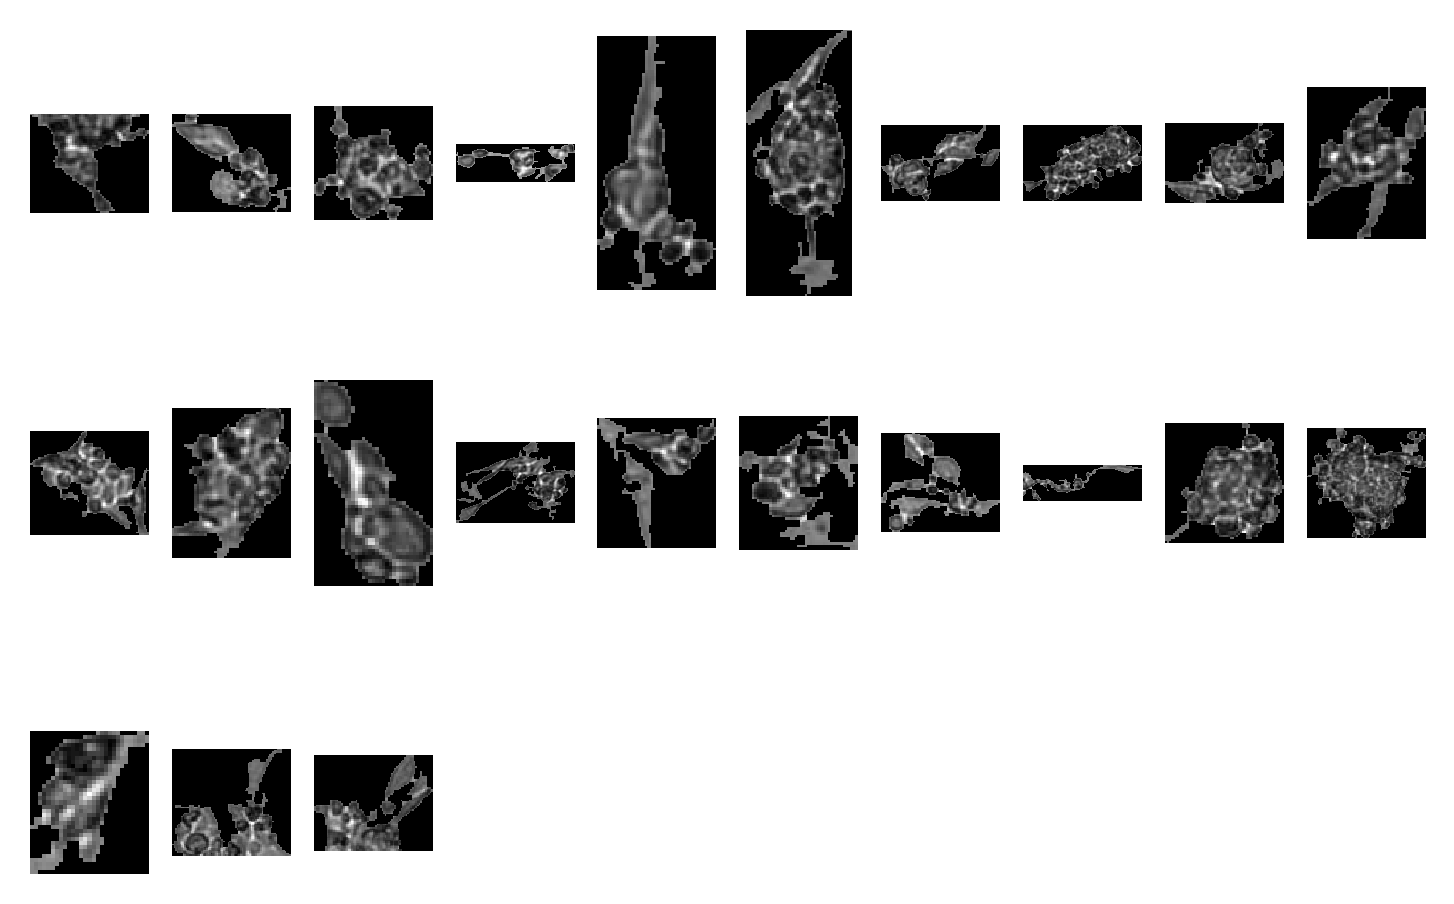

In [12]:
display_rois(raw_image, masks, labels)

/Users/peteyeh/miniconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


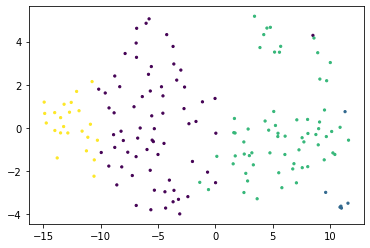

In [13]:
display_tsne(df)

# Classify cells on suspension image

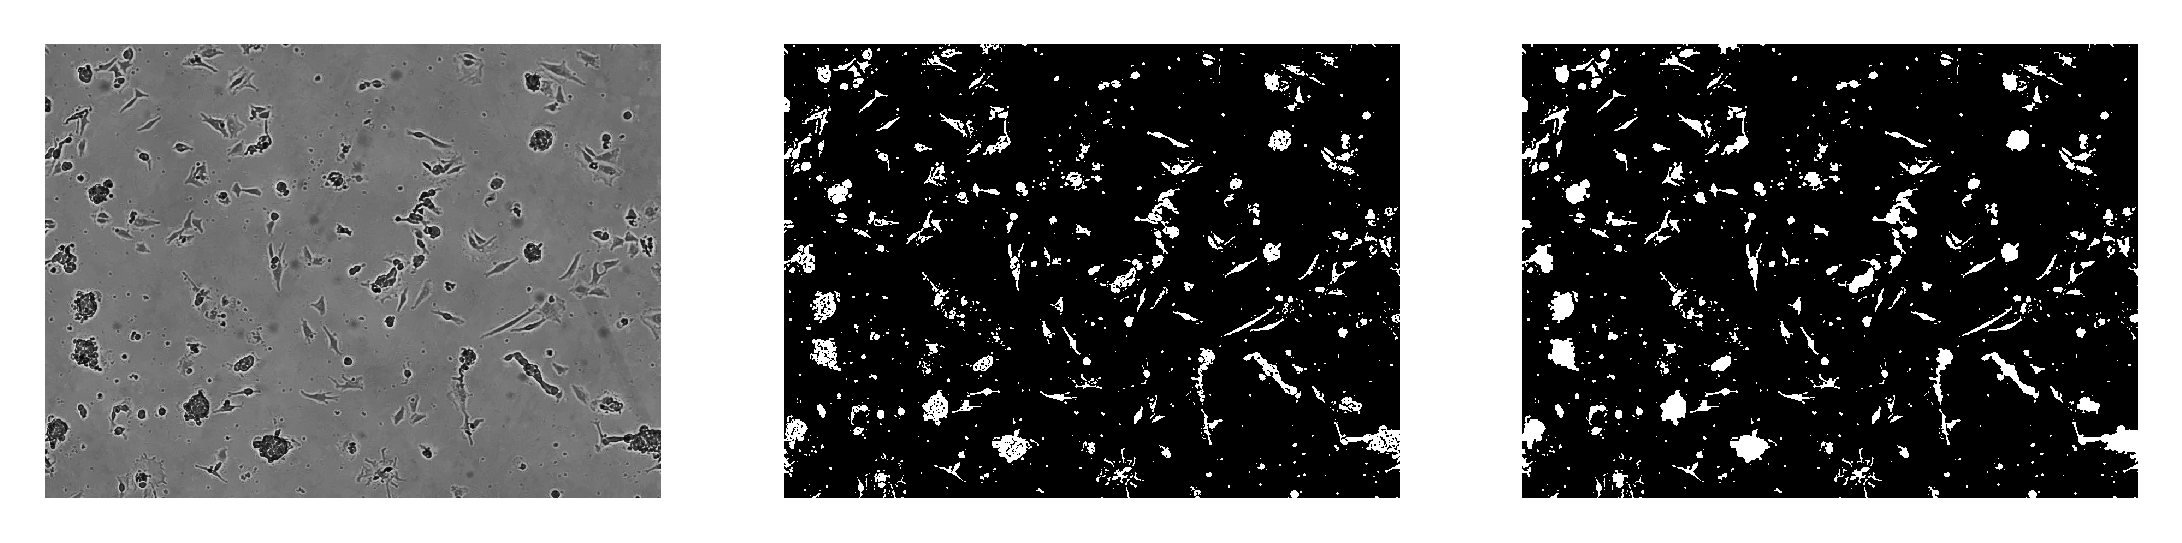

Class 0: 88 (50.29%)
Class 1: 3 (1.71%)
Class 2: 72 (41.14%)
Class 3: 12 (6.86%)


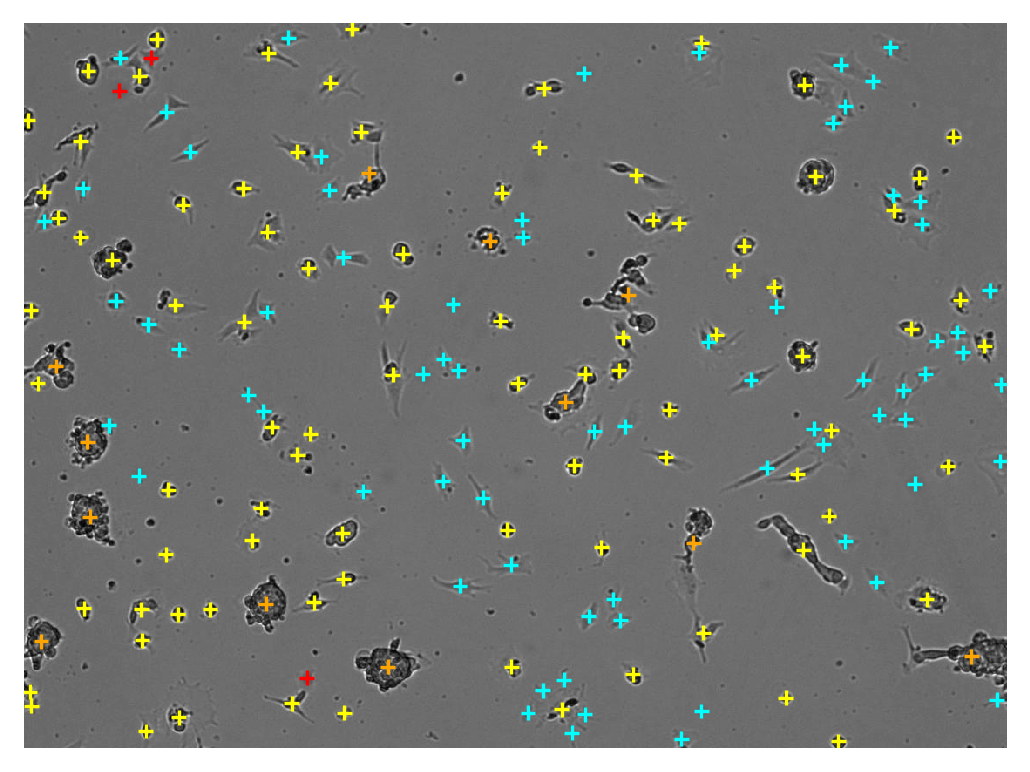

In [14]:
raw_image = cv2.imreadmulti('source_images/Suspension.tif')[1][0]
mask_image = get_mask_image(raw_image, params, display_images=True)
df, masks = extract_features(raw_image, mask_image)
df = process_features(df)
labels = kmeans.predict(df)
display_classifications(raw_image, df.index, labels)

Class 0, with 88 ROIs:


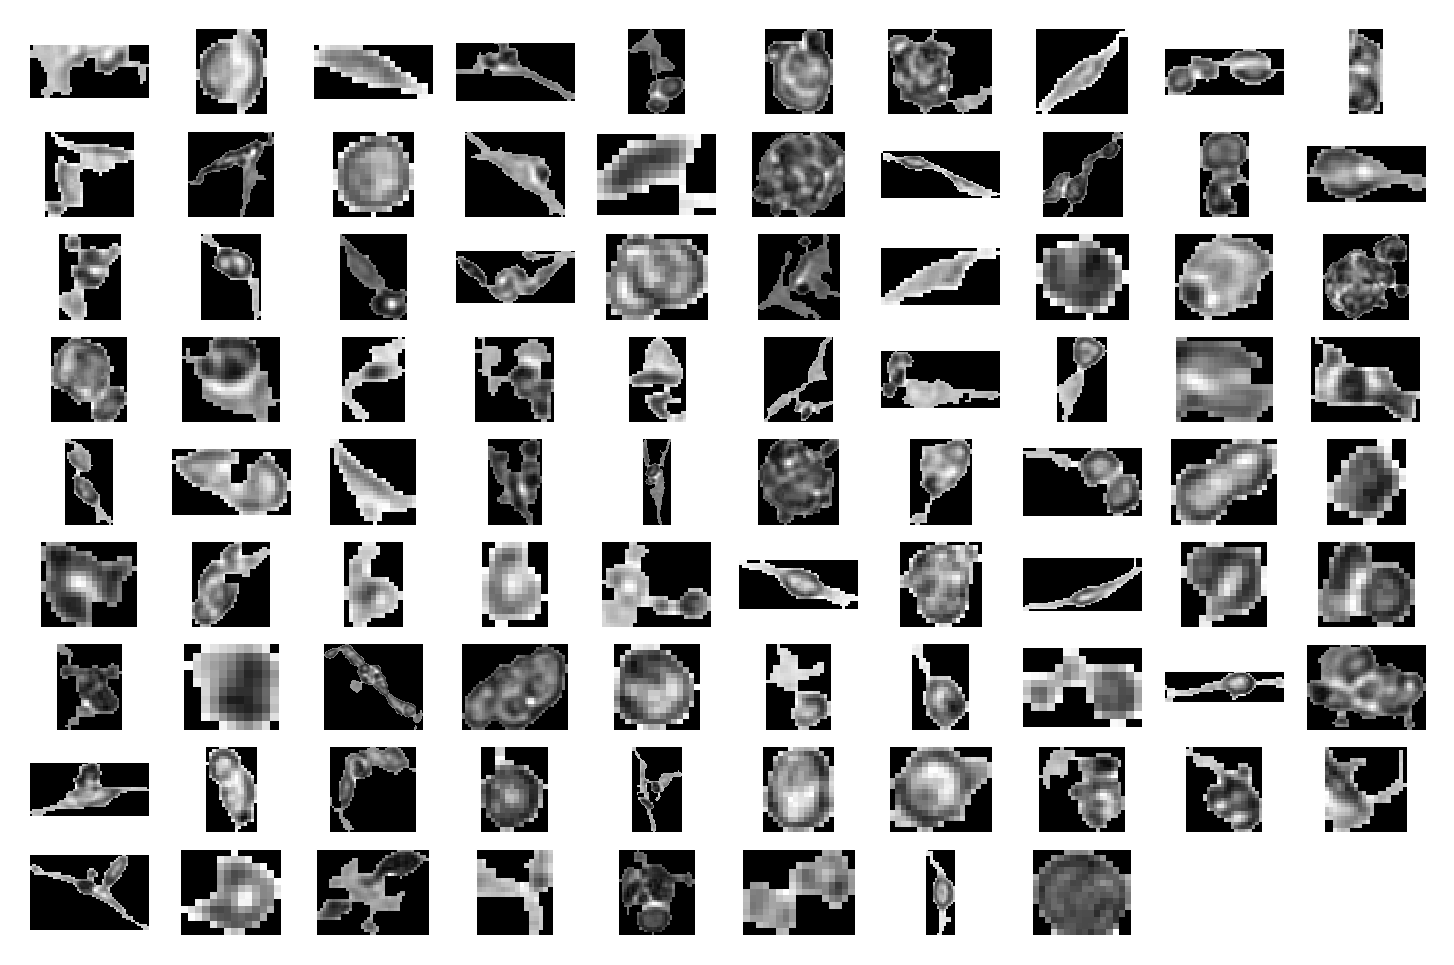

Class 1, with 3 ROIs:


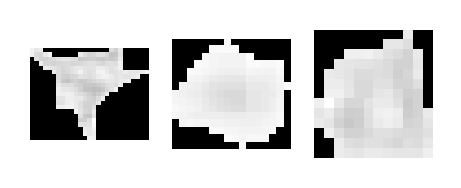

Class 2, with 72 ROIs:


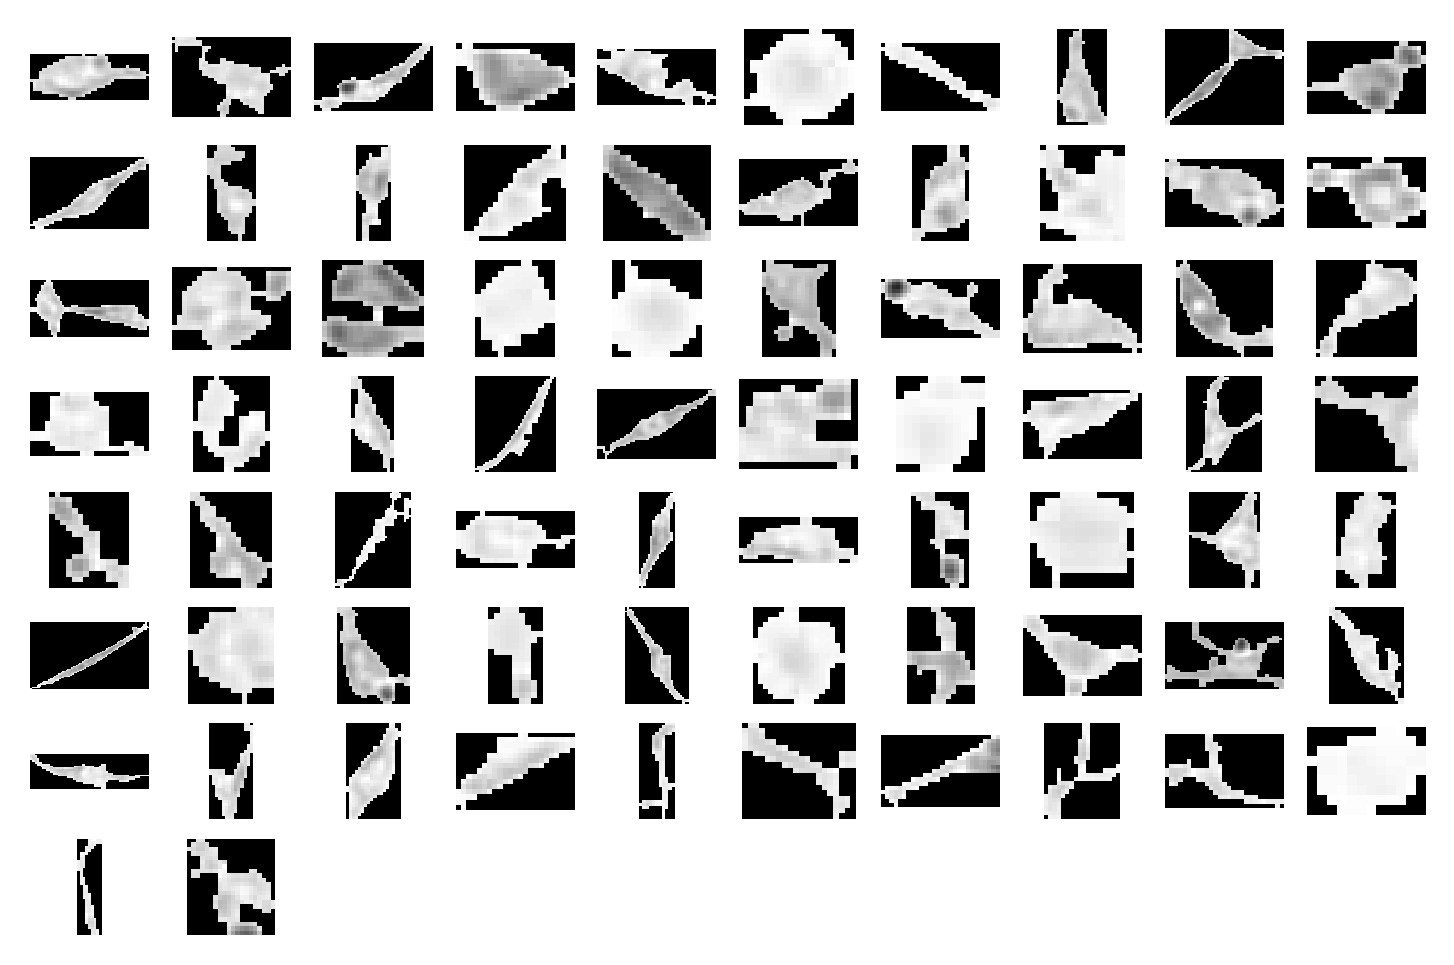

Class 3, with 12 ROIs:


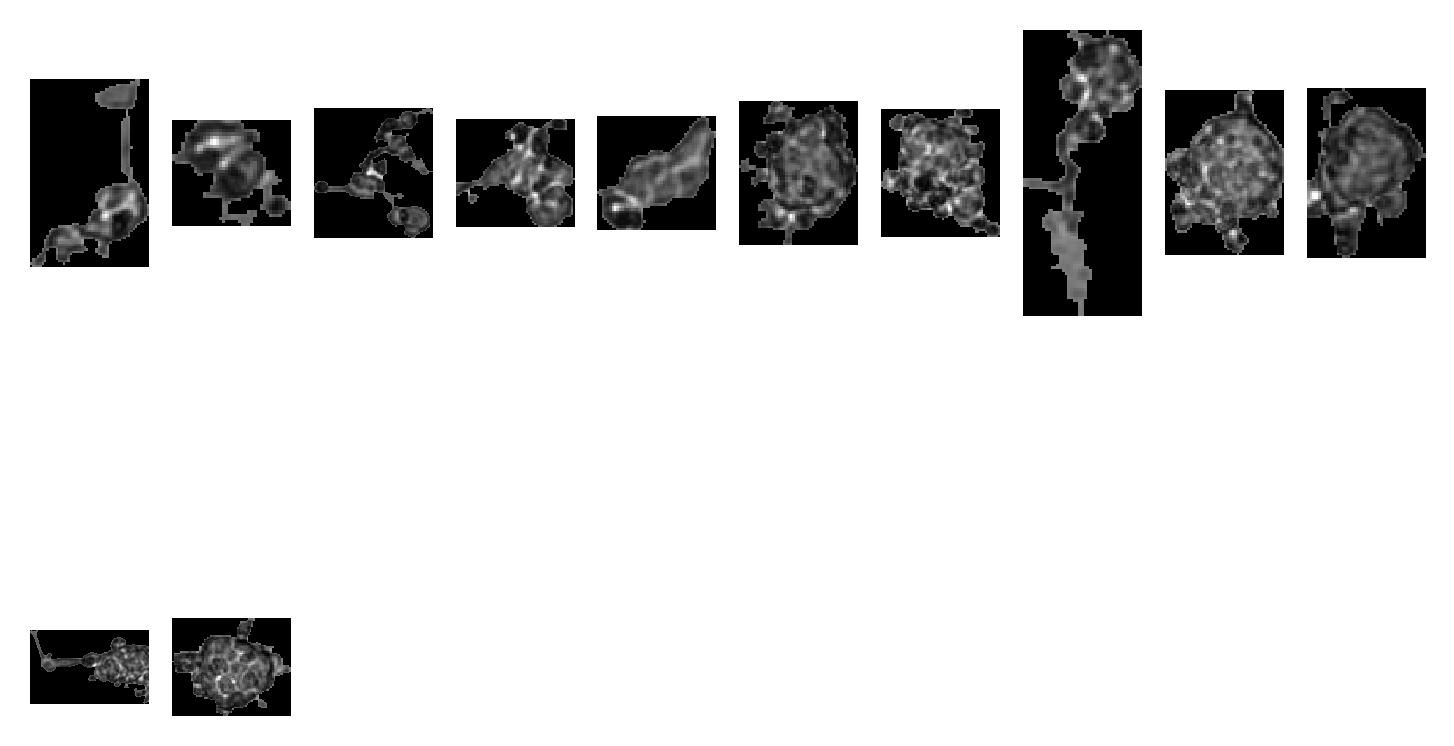

In [15]:
display_rois(raw_image, masks, labels)

/Users/peteyeh/miniconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


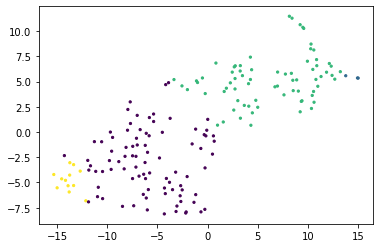

In [16]:
display_tsne(df)